In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import zipfile
import os

# Create a folder named "datasets" if it doesn't exist
dataset_folder = 'datasets'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# Unzip the archive into the "datasets" folder
local_zip = './merged-datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(dataset_folder)
zip_ref.close()

In [11]:
# Directory Management for Image datasets
data_dir_image = 'datasets/image'
data_dir_image = pathlib.Path(data_dir_image)
durian_images_dict = {
    'ripe' : list(data_dir_image.glob('ripe/*')),
    'unripe' : list(data_dir_image.glob('unripe/*')),
} 
durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [12]:
# Directory Management for Raw Image datasets
data_dir_raw_image = 'datasets/raw image'
data_dir_raw_image = pathlib.Path(data_dir_raw_image)
raw_durian_images_dict = {
    'ripe' : list(data_dir_raw_image.glob('ripe/*')),
    'unripe' : list(data_dir_raw_image.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [13]:
# Directory Management for Gas datasets
data_dir_gas = 'datasets/gas'
data_dir_gas = pathlib.Path(data_dir_gas)
durian_gas_dict = {
    'ripe' : list(data_dir_gas.glob('ripe/*')),
    'unripe' : list(data_dir_gas.glob('unripe/*')),
} 
gas_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
list(data_dir_gas.glob('*/*.png'))[:5]

[WindowsPath('datasets/gas/ripe/heatmap_10_percobaan_1.png'),
 WindowsPath('datasets/gas/ripe/heatmap_10_percobaan_2 - Copy.png'),
 WindowsPath('datasets/gas/ripe/heatmap_10_percobaan_2.png'),
 WindowsPath('datasets/gas/ripe/heatmap_10_percobaan_3.png'),
 WindowsPath('datasets/gas/ripe/heatmap_10_percobaan_4.png')]

In [14]:
X_image, y_image = [], []
for durian_ripeness, images in durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_image.append(resized_img)
        y_image.append(durian_labels_dict[durian_ripeness])
X_image = np.array(X_image)
y_image = np.array(y_image)
y_image

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
X_raw, y_raw = [], []
output_folder = "resized_images"
for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_raw.append(resized_img)
        y_raw.append(raw_durian_labels_dict[durian_ripeness])
        # Uncomment if you want to check all the resized images
        # output_name = f"{durian_ripeness}_{index}.jpg"
        # output_path = os.path.join(output_folder, output_name)
        # cv2.imwrite(output_path, resized_img)
X_raw = np.array(X_raw)
y_raw = np.array(y_raw)
y_raw

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
X_gas, y_gas = [], []
for durian_ripeness, images in durian_gas_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_gas.append(resized_img)
        y_gas.append(gas_labels_dict[durian_ripeness])
X_gas = np.array(X_gas)
y_gas = np.array(y_gas)
y_gas

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
from sklearn.model_selection import train_test_split
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(X_image, y_image, random_state=0)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, random_state=0)
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, random_state=0)
# Scaling Image dataset
X_train_scaled_image = X_train_image /255
X_test_scaled_image = X_test_image /255
# Scaling Raw dataset
X_train_scaled_raw = X_train_raw /255
X_test_scaled_raw = X_test_raw /255
# Scaling Gas dataset
X_train_scaled_gas = X_train_gas /255
X_test_scaled_gas = X_test_gas /255

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

input_shape_image = (200, 200, 3)  
input_shape_raw = (200, 200, 3)  
input_shape_gas = (200, 200, 3)  


# Define two separate input layers
input_image = Input(shape=input_shape_image)
input_raw = Input(shape=input_shape_raw)
input_gas = Input(shape=input_shape_gas)

In [19]:
convDim = 3  # Define the convolution dimension

In [20]:
# Convolution layer for Image dataset
conv1_image = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_image)(input_image)
pool1_image = MaxPooling2D(2, 2)(conv1_image)
drop1_image = Dropout(0.25)(pool1_image)

conv2_image = Conv2D(32, (convDim, convDim), activation='relu')(drop1_image)
pool2_image = MaxPooling2D(2, 2)(conv2_image)
drop2_image = Dropout(0.25)(pool2_image)

conv3_image = Conv2D(64, (convDim, convDim), activation='relu')(drop2_image)
pool3_image = MaxPooling2D(2, 2)(conv3_image)
drop3_image = Dropout(0.2)(pool3_image)

flat_image = Flatten()(drop3_image)

In [21]:
# Convolution layer for Raw dataset
conv1_raw = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_raw)(input_raw)
pool1_raw = MaxPooling2D(2, 2)(conv1_raw)
drop1_raw = Dropout(0.25)(pool1_raw)

conv2_raw = Conv2D(32, (convDim, convDim), activation='relu')(drop1_raw)
pool2_raw = MaxPooling2D(2, 2)(conv2_raw)
drop2_raw = Dropout(0.25)(pool2_raw)

conv3_raw = Conv2D(64, (convDim, convDim), activation='relu')(drop2_raw)
pool3_raw = MaxPooling2D(2, 2)(conv3_raw)
drop3_raw = Dropout(0.2)(pool3_raw)

flat_raw = Flatten()(drop3_raw)

In [22]:
# Convolution layer for Gas dataset
conv1_gas = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_gas)(input_gas)
pool1_gas = MaxPooling2D(2, 2)(conv1_gas)
drop1_gas = Dropout(0.25)(pool1_gas)

conv2_gas = Conv2D(32, (convDim, convDim), activation='relu')(drop1_gas)
pool2_gas = MaxPooling2D(2, 2)(conv2_gas)
drop2_gas = Dropout(0.25)(pool2_gas)

conv3_gas = Conv2D(64, (convDim, convDim), activation='relu')(drop2_gas)
pool3_gas = MaxPooling2D(2, 2)(conv3_gas)
drop3_gas = Dropout(0.2)(pool3_gas)

flat_gas = Flatten()(drop3_gas)

In [23]:
# Concatenate the flattened outputs
merged = concatenate([flat_image, flat_raw, flat_gas])

In [24]:
# Fully Connected Layer
fc1 = Dense(512, activation='relu')(merged)
drop_fc1 = Dropout(0.25)(fc1)

fc2 = Dense(128, activation='relu')(drop_fc1)
drop_fc2 = Dropout(0.25)(fc2)

fc3 = Dense(64, activation='relu')(drop_fc2)
drop_fc3 = Dropout(0.25)(fc3)

fc4 = Dense(8, activation='relu')(drop_fc3)
drop_fc4 = Dropout(0.25)(fc4)

output = Dense(1, activation='sigmoid')(drop_fc4)

# Create the model
model = Model(inputs=[input_image, input_raw, input_gas], outputs=output)

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
from tensorflow.keras.utils import plot_model

# Print model summary
# model.summary()
plot_model(model, to_file='custom-cnn.png', show_shapes=False, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\nAccuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
# callbacks=callbacks

In [27]:
# Train the model
model_fit = model.fit(
 (X_train_scaled_image, X_train_scaled_raw, X_train_scaled_gas), 
 y_train_image, 
 batch_size=32, 
 epochs=100,
 # callbacks=callbacks
 )

Epoch 1/100

2/2 [==============================] - 3s 1s/step - loss: 1.3353 - accuracy: 0.4500 - val_loss: 0.5967 - val_accuracy: 0.6000
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 1.3968 - accuracy: 0.5167 - val_loss: 0.6492 - val_accuracy: 0.6000
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 0.8230 - accuracy: 0.5000 - val_loss: 0.6452 - val_accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 2s 1s/step - loss: 0.6062 - accuracy: 0.6167 - val_loss: 0.6167 - val_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.5529 - accuracy: 0.7000 - val_loss: 0.6159 - val_accuracy: 0.8000
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 0.4450 - accuracy: 0.8333 - val_loss: 0.5218 - val_accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.4099 - accuracy: 0.8667 - val_loss: 0.4284 - val_accuracy: 1.0000
Epoch 8/100
2/2 [================

In [28]:
loss, accuracy = model.evaluate([X_test_scaled_image, X_test_scaled_raw, X_test_scaled_gas], [y_test_image, y_test_raw, y_test_gas])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 214ms/step - loss: 0.0148 - accuracy: 1.0000
Test Loss: 0.014782857149839401
Test Accuracy: 1.0


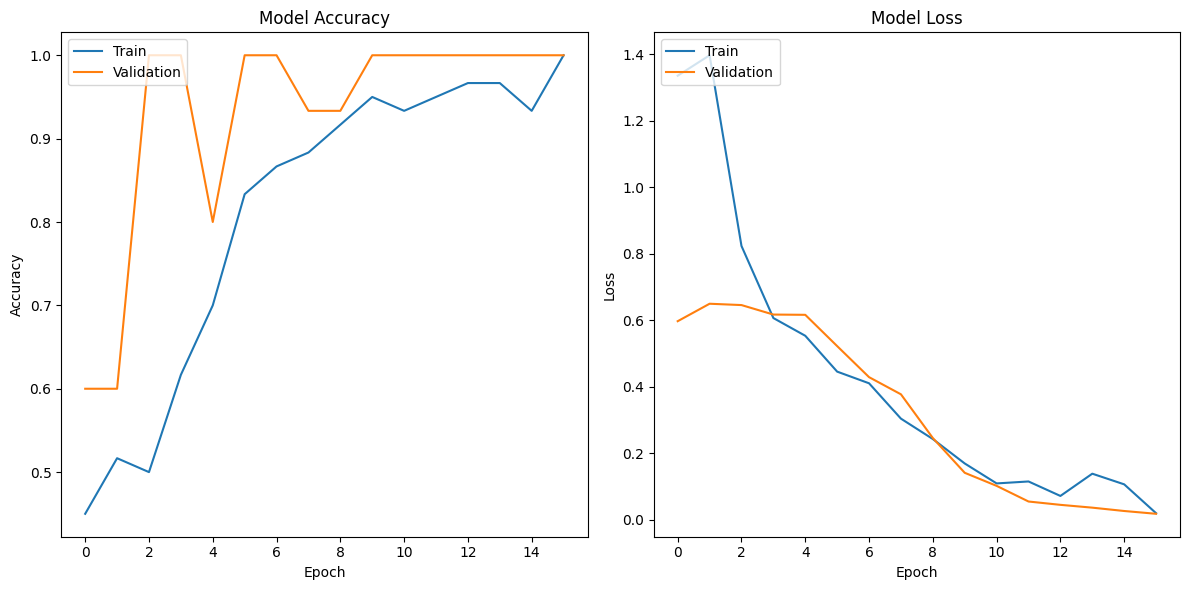

In [29]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 208ms/step


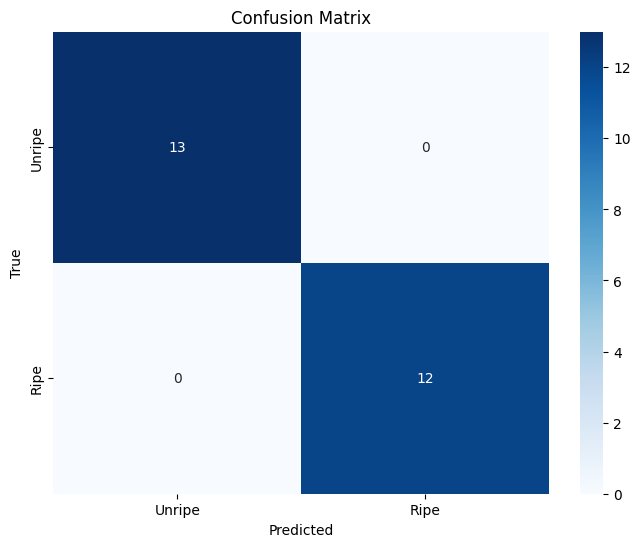

In [30]:
# Generate predictions on the test set
y_pred = model.predict([X_test_scaled_image, X_test_scaled_raw, X_test_scaled_gas])
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test_image, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
model.save('3MergedInput-CNN-Conv3.h5')

c:\Users\FISREKSATU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# from tensorflow.keras.preprocessing import image 

# # %%
# # Preprocess and Predict Image data
# test_image_path = "predictions/image/ripe_9.jpg"
# # test_image_path = "predictions/image/unripe_16.jpg"
# img = image.load_img(test_image_path)
# # plt.imshow(img)

# # %%
# # Preprocess and Predict Gas data
# test_gas_path = "predictions/gas/ripe_13.jpg"
# # test_gas_path = "predictions/gas/unripe_25.jpg"
# img_gas= image.load_img(test_gas_path)
# # plt.imshow(img_gas)

# # %%
# X_image = image.img_to_array(img)
# X_image = np.expand_dims(X_image, axis=0)
# X_image = X_image / 255

# X_gas = image.img_to_array(img_gas)
# X_gas = np.expand_dims(X_gas, axis=0)
# X_gas = X_gas / 255

# # %%
# predict = model.predict([X_image, X_gas])
# p = predict[0][0]
# p = '{:.10f}'.format(p)
# p